# CISS Subindex summary

In [1]:
import pandas as pd
import numpy as np
from fredapi import Fred
import quandl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt



fred = Fred(api_key='19107b38491c5732c271e63cdde0675a')


Some important functions

In [2]:
def reVol_abs_log(daily_price, Abs=False, Log=False):
    reVol = pd.DataFrame(data=daily_price.values,index=daily_price.index, columns={'price'})
    if Abs and Log:
        reVol['absLogRet'] = abs(np.log(reVol.price / reVol.price.shift()))

        reVol = reVol.absLogRet.resample('W').mean()
        #reVol.dropna(inplace=True)
    elif Abs == False and Log == False:
        reVol = reVol.price.resample('W').mean()
    
    elif Abs and Log == False:
        reVol['absRet'] = abs(reVol.price.pct_change())
        reVol = reVol.absRet.resample('W').mean()
    elif Abs == False and Log:
        reVol['LogRet'] = np.log(reVol.price / reVol.price.shift())
        reVol = reVol.LogRet.resample('W').mean()
    return reVol 

In [3]:
def calc_CDF(raw_data):
    '''raw_data is realised vol or cmax
    '''
    df_rank = pd.DataFrame(data= raw_data.rank(ascending=1,method= 'min'))#'first'))
                           #pd.qcut(raw_data, q=len(raw_data.unique()), labels=range(1,len(raw_data.unique())+1)))
    df_rank.rename(columns={df_rank.columns[0]:'Rank'},inplace=True)
    df_rank.Rank = df_rank.Rank.astype(int)
    df_rank['rankDivTotal'] = df_rank.Rank.values / len(raw_data) ##CDF
    #df_rank['CDF']  = norm.cdf(df_rank['rankDivTotal'])
    return df_rank

# Money market


### MM1:3-month London Interbank offered Rate(LIBOR),based on U.S. Dollar
realised volatility calculated as the weekly average of absolute daily rate changes

In [4]:
#fred_MM1 = Fred(api_key='19107b38491c5732c271e63cdde0675a')
mm1_raw_data = fred.get_series('USD3MTD156N',observation_start='1/4/1999')


In [5]:
reVol_abs_log(mm1_raw_data, Abs=True).head()


1999-01-10    0.001112
1999-01-17    0.004489
1999-01-24    0.000346
1999-01-31    0.000170
1999-02-07    0.000747
Freq: W-SUN, Name: absRet, dtype: float64

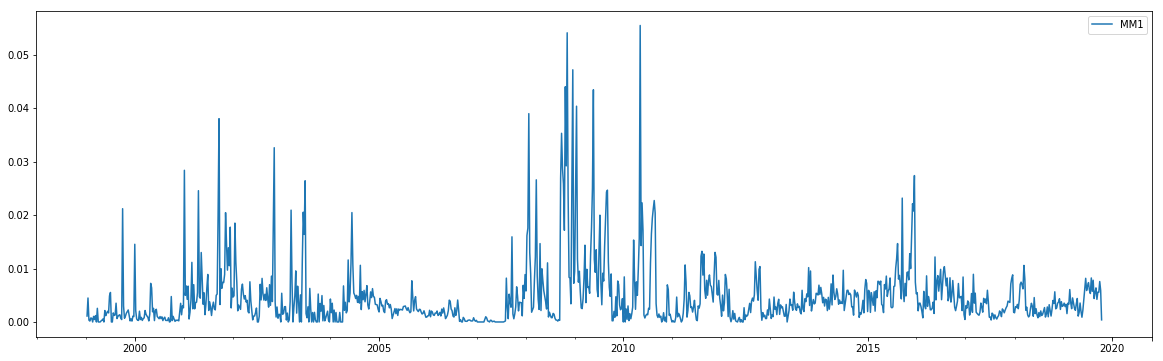

In [6]:
reVol_abs_log(mm1_raw_data, Abs=True).plot(figsize = (20,6), label = 'MM1')
plt.legend()

In [7]:
mm1_cdf = calc_CDF(reVol_abs_log(mm1_raw_data, Abs=True))


In [8]:
mm1_cdf.head()


,Rank,rankDivTotal
1999-01-10,245,0.225806
1999-01-17,728,0.670968
1999-01-24,119,0.109677
1999-01-31,82,0.075576
1999-02-07,178,0.164055


### MM2: 3-Month T-bill(Ted Spread) T-bill - Libor
weekly average of daily data

In [9]:
mm2_libor = fred.get_series('USD3MTD156N',observation_start='1/4/1999')
mm2_libor.fillna(method='ffill', inplace=True) 

In [11]:
mm2_tbill = fred.get_series('DTB3',observation_start='1/4/1999')
#plt.figure(figsize = (20,6))
#plt.plot(mm2_tbill, label = '3-Month Tbill')
#plt.legend()
#plt.show()

In [12]:
mm2_tbill.fillna(method='ffill', inplace=True) 

mm2_raw_data = mm2_libor - mm2_tbill

plt.figure(figsize = (20,6))
plt.plot(mm2_raw_data, label = '3 Month LIBOR$ - 3 Month Tbill')
plt.legend()
plt.show()

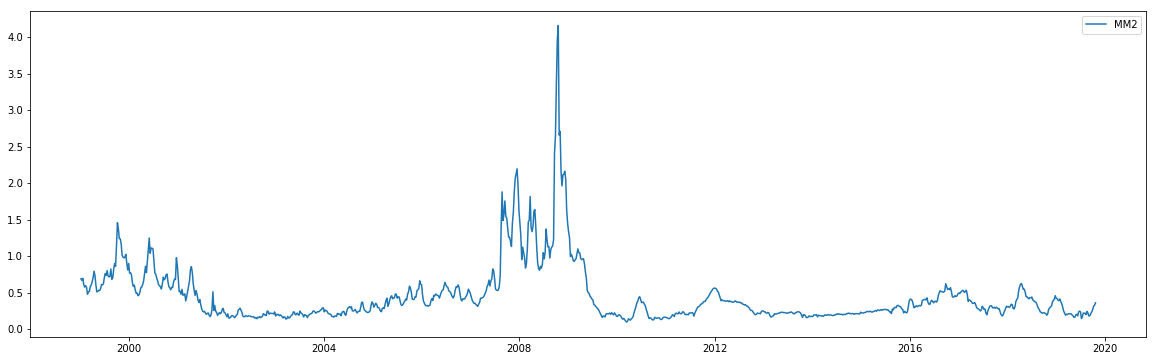

In [13]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(mm2_raw_data), label = 'MM2')
plt.legend()
plt.show()

In [14]:
mm2_raw_data.dropna(inplace=True)
mm2_cdf = calc_CDF(reVol_abs_log(mm2_raw_data))
mm2_cdf.head()

,Rank,rankDivTotal
1999-01-10,934,0.860829
1999-01-17,925,0.852535
1999-01-24,936,0.862673
1999-01-31,907,0.835945
1999-02-07,877,0.808295


### MM3:is still missing

In [15]:
MM = pd.concat([mm1_cdf.rankDivTotal,mm2_cdf.rankDivTotal],axis = 1)
MM.columns = ['mm1_cdf','mm2_cdf']
MM = MM.dropna()


In [16]:
MM['MM'] = (MM.mm1_cdf + MM.mm2_cdf)/2


In [17]:
MM.head()


,mm1_cdf,mm2_cdf,MM
1999-01-10,0.225806,0.860829,0.543318
1999-01-17,0.670968,0.852535,0.761751
1999-01-24,0.109677,0.862673,0.486175
1999-01-31,0.075576,0.835945,0.455760
1999-02-07,0.164055,0.808295,0.486175


#  Bond Market

### BM1:10-Year Treasury Constant Maturity Rate
realised volatility calculated as the weekly average of absolute daily yield changes

In [18]:
bm1_raw_data = fred.get_series('DGS10',observation_start='1/4/1999')


In [19]:
bm1_raw_data.tail()


2019-10-16    1.75
2019-10-17    1.76
2019-10-18    1.76
2019-10-21    1.80
2019-10-22    1.78
dtype: float64

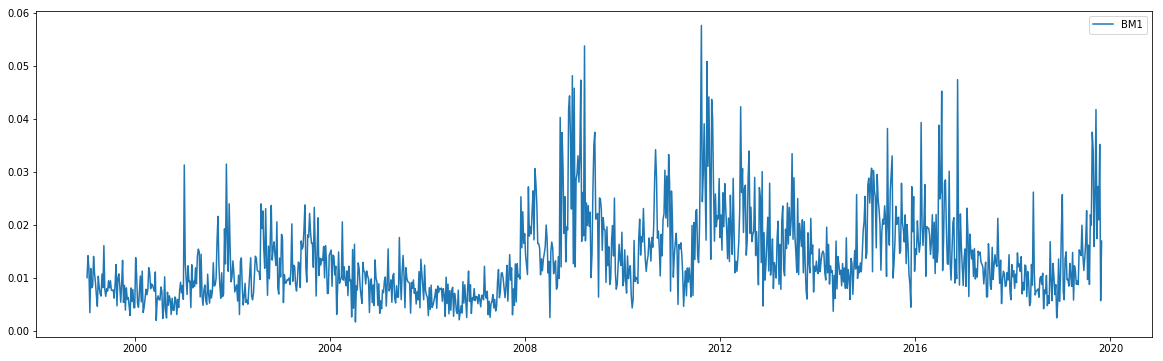

In [20]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(bm1_raw_data, Abs=True), label = 'BM1')
plt.legend()
plt.show()

In [21]:
reVol_abs_log(bm1_raw_data, Abs=True).head()


1999-01-10    0.010024
1999-01-17    0.014168
1999-01-24    0.011679
1999-01-31    0.003432
1999-02-07    0.011746
Freq: W-SUN, Name: absRet, dtype: float64

In [22]:
bm1_cdf = calc_CDF(reVol_abs_log(bm1_raw_data, Abs=True))


In [23]:
bm1_cdf.head()


,Rank,rankDivTotal
1999-01-10,428,0.394107
1999-01-17,685,0.630755
1999-01-24,544,0.500921
1999-01-31,28,0.025783
1999-02-07,547,0.503683


### BM2: Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
weekly average of daily data

In [24]:
bm2_raw_data = fred.get_series('AAA10Y',observation_start='1/4/1999')


In [25]:
bm2_raw_data.head()


1999-01-04    1.55
1999-01-05    1.54
1999-01-06    1.54
1999-01-07    1.52
1999-01-08    1.48
dtype: float64

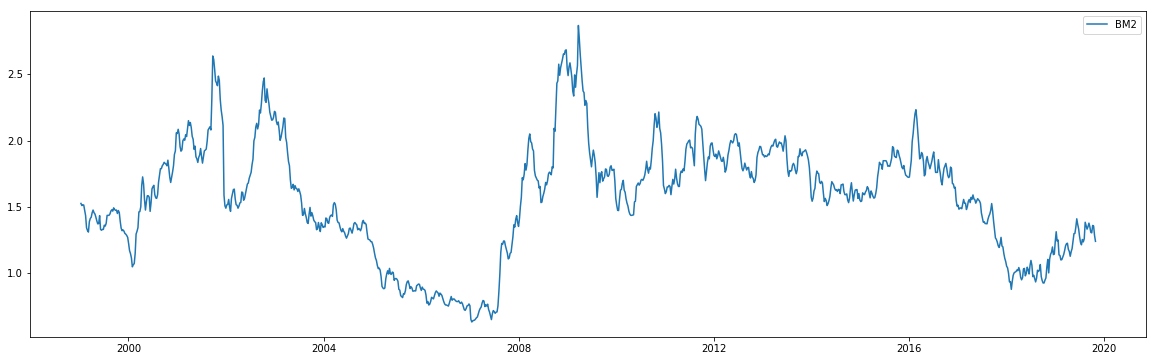

In [26]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(bm2_raw_data), label = 'BM2')
plt.legend()
plt.show()

In [27]:
reVol_abs_log(bm2_raw_data).head()


1999-01-10    1.526
1999-01-17    1.510
1999-01-24    1.515
1999-01-31    1.514
1999-02-07    1.476
Freq: W-SUN, Name: price, dtype: float64

In [28]:
bm2_cdf = calc_CDF(reVol_abs_log(bm2_raw_data))
bm2_cdf.head()


,Rank,rankDivTotal
1999-01-10,455,0.418969
1999-01-17,440,0.405157
1999-01-24,445,0.409761
1999-01-31,444,0.408840
1999-02-07,414,0.381215


### BM3: 10 years interest swap 
weekly average of daily data

In [29]:
BM3 = pd.read_excel('USSW10 BGN Curncy.xlsx',skiprows=6,index_col='Date')


In [30]:
BM3.sort_index(ascending=True,inplace=True)
BM3 = BM3['1999-01-04':]


In [31]:
BM3.index = BM3.index + np.timedelta64(2,'D')


In [32]:
BM3.tail()


,PX_LAST
Date,
2019-08-11,1.6304
2019-08-18,1.4454
2019-08-25,1.4504
2019-09-01,1.3817
2019-09-08,1.4458


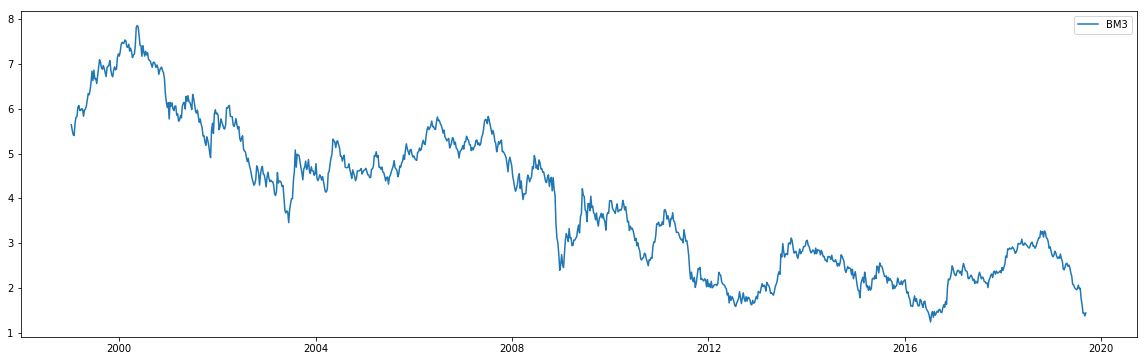

In [33]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(BM3), label = 'BM3')
plt.legend()
plt.show()

In [34]:
reVol_abs_log(BM3).tail()


Date
2019-08-11    1.6304
2019-08-18    1.4454
2019-08-25    1.4504
2019-09-01    1.3817
2019-09-08    1.4458
Freq: W-SUN, Name: price, dtype: float64

In [35]:
bm3_cdf = calc_CDF(BM3)

In [36]:
bm3_cdf.head()

,Rank,rankDivTotal
Date,,
1999-01-10,913,0.846154
1999-01-17,887,0.822057
1999-01-24,880,0.815570
1999-01-31,878,0.813716
1999-02-07,921,0.853568


In [37]:
BM = pd.concat([bm1_cdf.rankDivTotal,bm2_cdf.rankDivTotal,bm3_cdf.rankDivTotal],axis = 1)
BM.columns = ['bm1_cdf','bm2_cdf','bm3_cdf']
BM = BM.dropna()
BM['BM'] = (BM.bm1_cdf + BM.bm2_cdf + BM.bm3_cdf)/3

In [38]:
BM.head()

,bm1_cdf,bm2_cdf,bm3_cdf,BM
1999-01-10,0.394107,0.418969,0.846154,0.553076
1999-01-17,0.630755,0.405157,0.822057,0.619323
1999-01-24,0.500921,0.409761,0.815570,0.575417
1999-01-31,0.025783,0.408840,0.813716,0.416113
1999-02-07,0.503683,0.381215,0.853568,0.579489


# Equity market

### EM1 Realised volatility of the Datastram non-financial sector stock market index: 
realised volatility calculated as the weekly average of absolute daily log returns; transformed by its recursive sample CDF

In [39]:
em1 = pd.read_excel('ex-financial.xlsx', skiprows=1, index_col='Dates')
em1.rename(columns={'Last Price':'nonFinSec'},inplace=True)
em1 = em1['1999-01-04':]

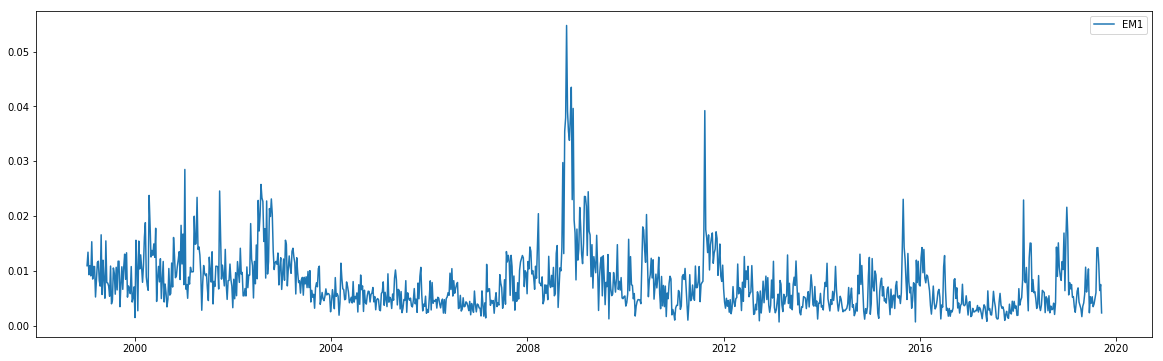

In [40]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(em1['nonFinSec'],Abs=True, Log=True), label = 'EM1')
plt.legend()
plt.show()

In [41]:
#the weekly average of absolute daily log returns
#em1['logRet'] = abs(np.log(em1['nonFinSec'] / em1['nonFinSec'].shift()))

In [42]:
#em1ReVol = em1.logRet.resample('W').mean()
#em1ReVol.dropna(inplace=True)

In [43]:
#em1ReVol.head()

In [44]:
#RelVolRank = pd.DataFrame(data=pd.qcut(em1ReVol, q=len(em1ReVol), labels=range(1,len(em1ReVol)+1)))
#RelVolRank.rename(columns={'logRet':'Rank'},inplace=True)
#RelVolRank.Rank = RelVolRank.Rank.astype(int)
#RelVolRank['rankDivTotal'] = RelVolRank.Rank.values / len(em1ReVol)

In [45]:
#from scipy.stats import norm
#RelVolRank['CDF']  = norm.cdf(RelVolRank['rankDivTotal'])

In [46]:
reVol_abs_log(em1['nonFinSec'],Abs=True, Log=True).head()

Dates
1999-01-10    0.010970
1999-01-17    0.013434
1999-01-24    0.009325
1999-01-31    0.010983
1999-02-07    0.009115
Freq: W-SUN, Name: absLogRet, dtype: float64

In [47]:
em1_cdf = calc_CDF(reVol_abs_log(em1['nonFinSec'],Abs=True, Log=True))

In [48]:
em1_cdf.head()

,Rank,rankDivTotal
Dates,,
1999-01-10,869,0.804630
1999-01-17,965,0.893519
1999-01-24,784,0.725926
1999-01-31,871,0.806481
1999-02-07,771,0.713889


### EM2 CMAX for the Datastream non-financial sector stock market index: 
maximum cumulated index losses over a moving 2-year window
##### missing weekly data

fakeWeekly = pd.DataFrame (data=em1.nonFinSec.resample('W').mean() )

fakeWeekly['loss'] = fakeWeekly.nonFinSec.pct_change()#rolling(window=104)

fakeWeekly['cmax'] = 0
for i in range(104, len(fakeWeekly.index)):
    fakeWeekly.cmax.iloc[i] = (1 - fakeWeekly.iloc[i].loss) / max(fakeWeekly.iloc[i-104:i].loss)

fakeWeekly = fakeWeekly.iloc[105:]['cmax']

em2_cdf = calc_CDF(fakeWeekly)

em2_cdf.head()

In [49]:
em2_weekly = pd.read_excel('Book1.xlsx', sheet_name='Sheet2', skiprows=4)[1:]

In [50]:
em2_weekly.rename(columns={'Dates':'Date', 'SPXXFISP Index':'nonFinSec'}, inplace=True)
em2_weekly.Date = pd.to_datetime(em2_weekly.Date) + np.timedelta64(2,'D')
em2_weekly.set_index('Date', inplace=True)
em2_weekly['loss'] = em2_weekly.nonFinSec.pct_change()

In [52]:
em2_weekly['cmax'] = 0
for i in range(104, len(em2_weekly.index)):
    em2_weekly.cmax.iloc[i] = 1 - ((em2_weekly.iloc[i].loss) / max(em2_weekly.iloc[i-104:i].loss))

/Users/keyang/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [53]:
em2_weekly1 = em2_weekly.iloc[105:]['cmax']

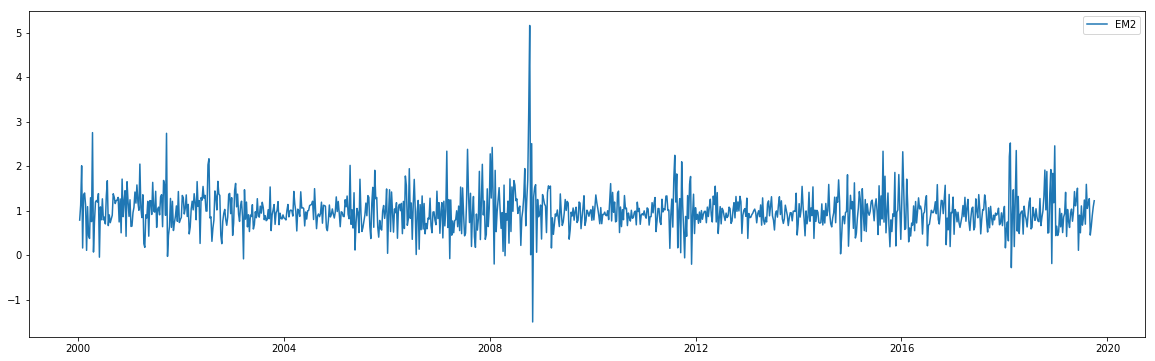

In [54]:
plt.figure(figsize = (20,6))
plt.plot(em2_weekly1, label = 'EM2')
plt.legend()
plt.show()

In [55]:
em2_cdf = calc_CDF(em2_weekly1)

In [56]:
em2_cdf.head()

,Rank,rankDivTotal
Date,,
2000-01-16,299,0.290573
2000-01-23,721,0.700680
2000-01-30,1007,0.978620
2000-02-06,25,0.024295
2000-02-13,900,0.874636


### EM3: Stock-bond correlation -> S&P 500 total return / price index; 10-Year Treasury Constant Maturity Rate

daily log returns of the Datastream total stock market price index

### data need further modified

In [57]:
total_market_index_dataframe = pd.read_excel('SPXT.xlsx',skiprows=6,index_col='Date')
total_market_index_dataframe.sort_index(ascending=True, inplace=True)
total_market_index_series = total_market_index_dataframe['PX_LAST']
total_market_index_series = total_market_index_series['1995-01-10':]

total_market_index_logRet = np.log(total_market_index_series / total_market_index_series.shift())
total_market_index_logRet = total_market_index_logRet.dropna()
total_market_index_logRet.head()

Date
1995-01-11   -0.000035
1995-01-12   -0.000052
1995-01-13    0.009523
1995-01-16    0.007295
1995-01-17    0.001459
Name: PX_LAST, dtype: float64

plt.figure(figsize = (20,6))
plt.plot(total_market_index_series, label = 'S&P 500 total return / price index')
plt.legend()
plt.show()

In [58]:
treasury_rate_raw_data = fred.get_series('AAA10Y',observation_start='1/10/1995')
treasury_rate_raw_data.head(10)


1995-01-10    0.61
1995-01-11    0.67
1995-01-12    0.68
1995-01-13    0.72
1995-01-16     NaN
1995-01-17    0.72
1995-01-18    0.70
1995-01-19    0.70
1995-01-20    0.69
1995-01-23    0.71
dtype: float64

plt.figure(figsize = (20,6))
plt.plot(treasury_rate_raw_data, label = '10-Year Treasury Constant Maturity Rate')
plt.legend()
plt.show()

In [59]:
em3_dataframe = pd.concat([total_market_index_series,treasury_rate_raw_data],axis=1)
em3_dataframe.columns = ['Total_market','Treasury_rate']


In [60]:
em3_dataframe.head()


,Total_market,Treasury_rate
1995-01-10,579.05,0.61
1995-01-11,579.03,0.67
1995-01-12,579.00,0.68
1995-01-13,584.54,0.72
1995-01-16,588.82,NaN


In [61]:
#em3_dataframe.fillna(method='ffill',inplace=True)
#em3_dataframe = em3_dataframe.loc['1999-01-04':]
em3_dataframe.fillna(method='bfill',inplace=True)


In [62]:
em3_corr = pd.DataFrame(index=em3_dataframe.index, columns={'corrCoeff_diff'})
for i in range(1040,len(em3_dataframe)):
    four_year_start_index = i-1040
    four_week_start_index = i - 20
    four_year_dataframe = em3_dataframe.iloc[four_year_start_index:i]
    four_week_dataframe = em3_dataframe.iloc[four_week_start_index:i]
    four_year_coeff = np.corrcoef(four_year_dataframe['Total_market'],four_year_dataframe['Treasury_rate'])[0][1]
    four_week_coeff = np.corrcoef(four_week_dataframe['Total_market'],four_week_dataframe['Treasury_rate'])[0][1]
    coeff_diff = four_year_coeff-four_week_coeff
    em3_corr.corrCoeff_diff.iloc[i] = coeff_diff
    

In [63]:
em3_corr[em3_corr['corrCoeff_diff'] < 0 ] = 0
em3_corr = em3_corr.dropna()


In [64]:
em3_corr = em3_corr[['corrCoeff_diff']].astype('float').resample('W').mean()
em3_corr.head()


,corrCoeff_diff
1999-01-10,1.208442
1999-01-17,1.181949
1999-01-24,0.928822
1999-01-31,0.976436
1999-02-07,0.988062


In [65]:
em3_corr.dropna(inplace=True)
em3_corr = em3_corr.corrCoeff_diff.astype(float).resample('W').mean()
em3_corr.head()


1999-01-10    1.208442
1999-01-17    1.181949
1999-01-24    0.928822
1999-01-31    0.976436
1999-02-07    0.988062
Freq: W-SUN, Name: corrCoeff_diff, dtype: float64

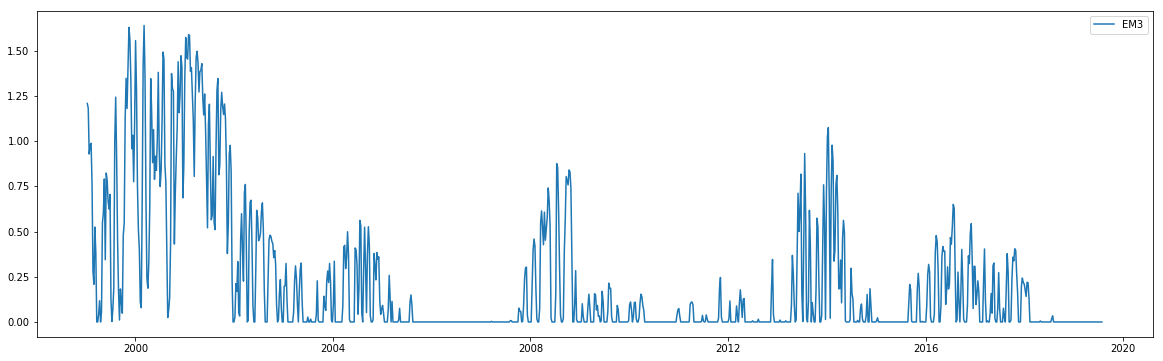

In [66]:
plt.figure(figsize = (20,6))
plt.plot(em3_corr, label = 'EM3')
plt.legend()
plt.show()

In [67]:
em3_corr = calc_CDF(em3_corr)
em3_corr.head()


,Rank,rankDivTotal
1999-01-10,1029,0.958993
1999-01-17,1025,0.955266
1999-01-24,996,0.928239
1999-01-31,1001,0.932898
1999-02-07,1004,0.935694


In [68]:
EM = pd.concat([em1_cdf.rankDivTotal,em2_cdf.rankDivTotal,em3_corr.rankDivTotal],axis = 1)
EM.columns = ['em1_cdf','em2_cdf','em3_corr']
EM = EM.dropna()
EM['EM'] = (EM.em1_cdf + EM.em2_cdf + EM.em3_corr)/3


In [69]:
EM.head()


,em1_cdf,em2_cdf,em3_corr,EM
2000-01-16,0.787963,0.290573,0.892824,0.657120
2000-01-23,0.089815,0.700680,0.835974,0.542156
2000-01-30,0.932407,0.978620,0.798695,0.903241
2000-02-06,0.766667,0.024295,0.636533,0.475832
2000-02-13,0.882407,0.874636,0.600186,0.785743


# Financial intermediaries

### FI1: S&P bank sector index

### bank sector data time range need to be futher adjusted

In [70]:
#total_market_index_dataframe = pd.read_excel('SPXT.xlsx',skiprows=6)
bank_sector_index_dataframe = pd.read_excel('SPSIBK.xlsx',skiprows=6)#,index_col='Date')
#total_market_index_dataframe.set_index('Date',inplace=True)
bank_sector_index_dataframe.set_index('Date',inplace=True)

plt.figure(figsize = (20,6))
plt.plot(bank_sector_index_dataframe.PX_LAST, label = 'S&P Bank Sector Index')
plt.legend()
plt.show()

In [71]:
bank_sector_index_dataframe.sort_index(ascending=True, inplace=True)
bank_sector_logRet =np.log(bank_sector_index_dataframe.PX_LAST / bank_sector_index_dataframe.PX_LAST.shift())



In [72]:
bank_sector_logRet.head()


Date
2003-06-20         NaN
2003-06-23   -0.017553
2003-06-24    0.002886
2003-06-25   -0.000162
2003-06-26    0.003060
Name: PX_LAST, dtype: float64

In [73]:
total_market_index_logRet.head()


Date
1995-01-11   -0.000035
1995-01-12   -0.000052
1995-01-13    0.009523
1995-01-16    0.007295
1995-01-17    0.001459
Name: PX_LAST, dtype: float64

In [74]:
from sklearn.linear_model import LinearRegression
fI1_dataframe = pd.concat([bank_sector_logRet,total_market_index_logRet],axis=1)
fI1_dataframe.columns = ['Bank_sector','Total_market']


In [75]:
fI1_dataframe = fI1_dataframe.loc['1996-12-09':]


In [76]:
#fI1_dataframe.fillna(method='bfill',inplace=True)
#### bank sector fill by lastest might cause problem！！！
fI1_dataframe.dropna(inplace=True)


In [77]:
fI1_idio_ret = pd.DataFrame(index=fI1_dataframe.index, columns={'idio_ret'})

for index in range(522,len(fI1_dataframe)):
    starting_index = index-522
    trainning_dataframe = fI1_dataframe.iloc[starting_index:index]
    model = LinearRegression()
    model.fit(X=trainning_dataframe['Bank_sector'].values.reshape(-1,1), y=trainning_dataframe['Total_market'])
    
    coefficient = model.coef_[0]
    intercept =  model.intercept_
    predicted_value = model.predict(fI1_dataframe.iloc[index]['Bank_sector'].reshape(-1,1))
    diff = abs(predicted_value-fI1_dataframe.iloc[index]['Total_market'])   
    fI1_idio_ret.idio_ret.iloc[index] = diff[0]


In [78]:
fI1_idio_ret.dropna(inplace=True)


In [79]:
fI1_idio_ret.idio_ret = fI1_idio_ret.idio_ret.astype(float)
fI1_idio_ret.idio_ret.resample('W').mean().head()


Date
2005-07-24    0.002588
2005-07-31    0.002657
2005-08-07    0.001280
2005-08-14    0.002073
2005-08-21    0.001728
Freq: W-SUN, Name: idio_ret, dtype: float64

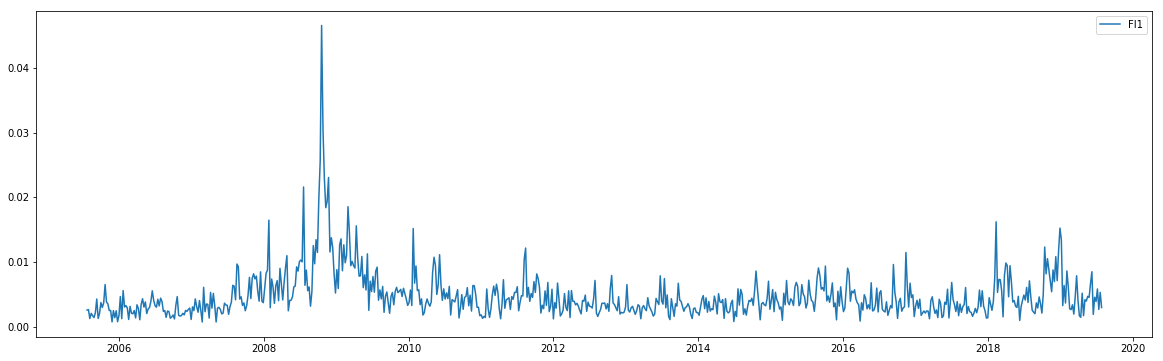

In [83]:
plt.figure(figsize = (20,6))
plt.plot(fI1_idio_ret.idio_ret.resample('W').mean(), label = 'FI1')
plt.legend()
plt.show()


In [81]:
fi1_cdf = calc_CDF(fI1_idio_ret.idio_ret.resample('W').mean())


In [82]:
fi1_cdf.head()


,Rank,rankDivTotal
Date,,
2005-07-24,173,0.236339
2005-07-31,178,0.243169
2005-08-07,21,0.028689
2005-08-14,90,0.122951
2005-08-21,61,0.083333


### FI2 is still missing

### FI3

In [ ]:
#bank_sector_index_dataframe = pd.read_excel('SPSIBK.xlsx')#,index_col='Date'


In [84]:
FI3_data = pd.read_excel('Book1.xlsx', sheet_name='Sheet1', skiprows=4)[1:]


FI3_data.rename(columns={'Dates':'Date', 'SPSIBK Index':'bankSector'}, inplace=True)
FI3_data.Date = pd.to_datetime(FI3_data.Date) + np.timedelta64(2,'D')
FI3_data.set_index('Date', inplace=True)

FI3_data = FI3_data.resample('W').mean()

FI3_data['loss'] = FI3_data.bankSector.pct_change()

FI3_data['cmax'] = 0
for i in range(104, len(FI3_data.index)):
    FI3_data.cmax.iloc[i] = 1 - ((FI3_data.iloc[i].loss) / max(FI3_data.iloc[i-104:i].loss))

FI3_data1 = FI3_data.iloc[105:]['cmax']
FI3_data_cdf1 = calc_CDF(FI3_data1)


/Users/keyang/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [85]:
FI3_data_cdf2 = calc_CDF(FI3_data.bankSector)

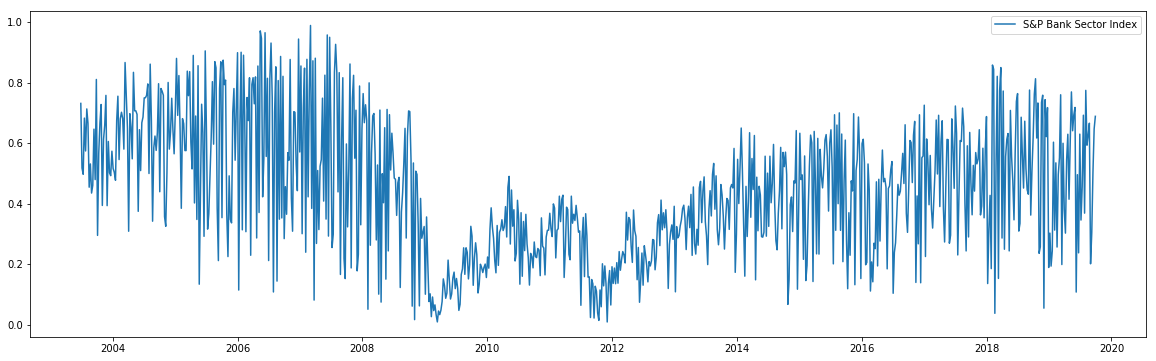

In [86]:
plt.figure(figsize = (20,6))
plt.plot(np.sqrt(em2_cdf.rankDivTotal * FI3_data_cdf2.rankDivTotal), label = 'S&P Bank Sector Index')
plt.legend()
plt.show()

In [87]:
FI3_data_cdf = np.sqrt(em2_cdf.rankDivTotal * FI3_data_cdf2.rankDivTotal)
FI3_data_cdf.dropna(inplace=True)

In [88]:
FI3_data_cdf

Date
2003-06-29    0.731170
2003-07-06    0.517711
2003-07-13    0.497144
2003-07-20    0.682680
2003-07-27    0.574135
2003-08-03    0.713002
2003-08-10    0.665072
2003-08-17    0.454464
2003-08-24    0.531272
2003-08-31    0.435104
2003-09-07    0.460762
2003-09-14    0.646181
2003-09-21    0.479610
2003-09-28    0.810318
2003-10-05    0.295259
2003-10-12    0.566788
2003-10-19    0.667050
2003-10-26    0.727645
2003-11-02    0.394155
2003-11-09    0.612612
2003-11-16    0.659053
2003-11-23    0.757729
2003-11-30    0.393499
2003-12-07    0.605453
2003-12-14    0.501853
2003-12-21    0.492574
2003-12-28    0.573358
2004-01-04    0.516449
2004-01-11    0.503513
2004-01-18    0.477304
                ...   
2019-03-10    0.759762
2019-03-17    0.198963
2019-03-24    0.599524
2019-03-31    0.382197
2019-04-07    0.302780
2019-04-14    0.544860
2019-04-21    0.629338
2019-04-28    0.414696
2019-05-05    0.604108
2019-05-12    0.769163
2019-05-19    0.640979
2019-05-26    0.693091
2019-0

In [89]:
FI = pd.concat([fi1_cdf.rankDivTotal, FI3_data_cdf],axis = 1)
FI.columns = ['fi1_cdf','fi3_cdf']
FI = FI.dropna()
FI['FI'] = (FI.fi1_cdf+FI.fi3_cdf)/2

FI = pd.concat([fi1_cdf.rankDivTotal],axis = 1)
FI.columns = ['fi1_cdf']
FI = FI.dropna()
FI['FI'] = (FI.fi1_cdf)/1


In [90]:
FI.loc['2008-01-01':].head(10)


,fi1_cdf,fi3_cdf,FI
Date,,,
2008-01-06,0.770492,0.763628,0.767060
2008-01-13,0.893443,0.667487,0.780465
2008-01-20,0.908470,0.726737,0.817604
2008-01-27,0.986339,0.674329,0.830334
2008-02-03,0.307377,0.051280,0.179328
2008-02-10,0.863388,0.799129,0.831259
2008-02-17,0.795082,0.262716,0.528899
2008-02-24,0.446721,0.567631,0.507176
2008-03-02,0.810109,0.689863,0.749986


# Foreign exchange market

### FX1:U.S. / Euro Foreign Exchange Rate
#### realised volatility calculated as the weekly average of absolute daily log foreign exchange returns
 daily price contains NaN, might affect weekly average
 


In [91]:
fx1_raw_data = fred.get_series('DEXUSEU',observation_start='1/4/1999')
#fx1_raw_data.replace({np.NaN:0}, inplace=True)


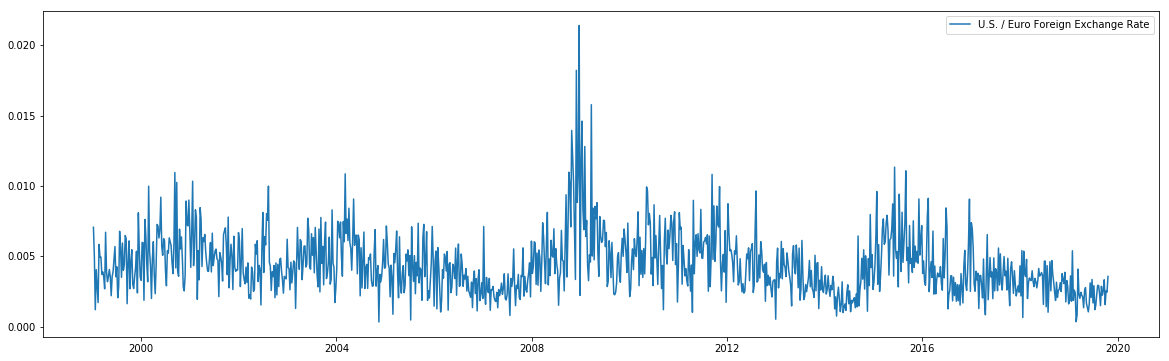

In [92]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(fx1_raw_data, Abs=True, Log=True), label = 'U.S. / Euro Foreign Exchange Rate')
plt.legend()
plt.show()

In [ ]:
#abs(np.log(fx1_raw_data / fx1_raw_data.shift())).resample('W').mean()


In [93]:
reVol_abs_log(fx1_raw_data, Abs=True, Log=True).tail()


2019-09-22    0.003334
2019-09-29    0.001567
2019-10-06    0.002558
2019-10-13    0.002458
2019-10-20    0.003575
Freq: W-SUN, Name: absLogRet, dtype: float64

In [94]:
fx1_cdf = calc_CDF(reVol_abs_log(fx1_raw_data,Abs=True, Log=True))


In [95]:
fx1_cdf.head()


,Rank,rankDivTotal
1999-01-10,972,0.895853
1999-01-17,727,0.670046
1999-01-24,24,0.022120
1999-01-31,540,0.497696
1999-02-07,253,0.233180


### FX2:Japan / U.S. Foreign Exchange Rate

In [96]:
fx2_raw_data = fred.get_series('DEXJPUS',observation_start='1/4/1999')


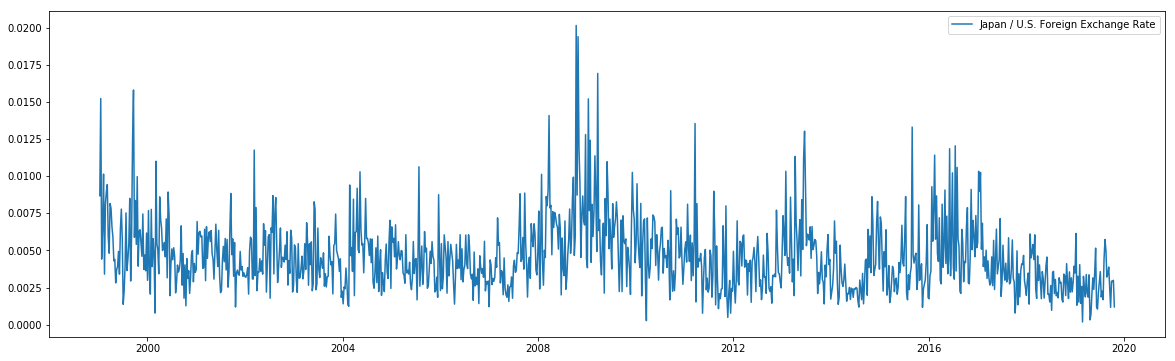

In [97]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(fx2_raw_data, Abs=True, Log=True), label = 'Japan / U.S. Foreign Exchange Rate')
plt.legend()
plt.show()

In [98]:
reVol_abs_log(fx2_raw_data, Abs=True, Log=True).tail()


2019-09-22    0.001166
2019-09-29    0.002935
2019-10-06    0.002905
2019-10-13    0.002989
2019-10-20    0.001197
Freq: W-SUN, Name: absLogRet, dtype: float64

In [99]:
fx2_cdf = calc_CDF(reVol_abs_log(fx2_raw_data,Abs=True, Log=True))
fx2_cdf.head()


,Rank,rankDivTotal
1999-01-10,1028,0.947465
1999-01-17,1081,0.996313
1999-01-24,591,0.544700
1999-01-31,913,0.841475
1999-02-07,1054,0.971429


### FX3: U.S. / U.K. Foreign Exchange Rate

In [100]:
fx3_raw_data = fred.get_series('DEXUSUK',observation_start='1/4/1999')


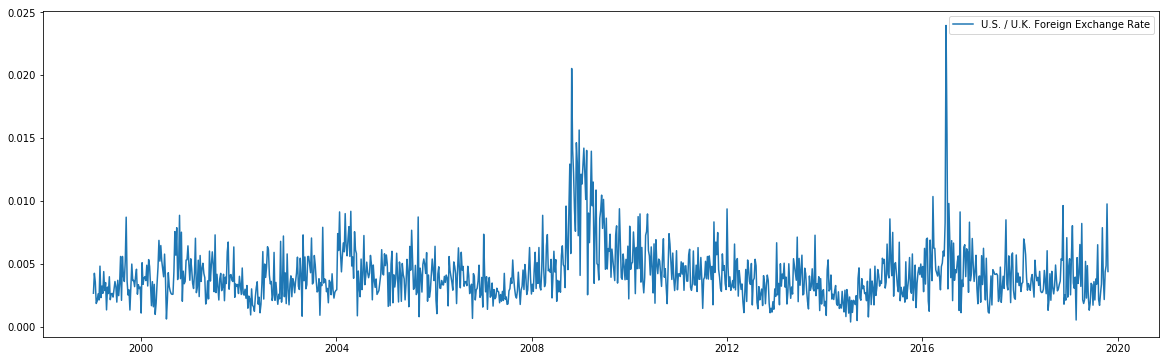

In [101]:
plt.figure(figsize = (20,6))
plt.plot(reVol_abs_log(fx3_raw_data,Abs=True, Log=True), label = 'U.S. / U.K. Foreign Exchange Rate')
plt.legend()
plt.show()

In [102]:
fx3_cdf = calc_CDF(reVol_abs_log(fx3_raw_data,Abs=True, Log=True))


In [103]:
fx3_cdf.head()


,Rank,rankDivTotal
1999-01-10,243,0.223963
1999-01-17,676,0.623041
1999-01-24,483,0.445161
1999-01-31,86,0.079263
1999-02-07,116,0.106912


In [104]:
FX = pd.concat([fx1_cdf.rankDivTotal,fx2_cdf.rankDivTotal,fx3_cdf.rankDivTotal],axis = 1)
FX.columns = ['fx1_cdf','fx2_cdf','fx3_cdf']
FX = FX.dropna()
FX['FX'] = (FX.fx1_cdf + FX.fx2_cdf + FX.fx3_cdf)/3


In [105]:
FX.head()


,fx1_cdf,fx2_cdf,fx3_cdf,FX
1999-01-10,0.895853,0.947465,0.223963,0.689094
1999-01-17,0.670046,0.996313,0.623041,0.763134
1999-01-24,0.022120,0.544700,0.445161,0.337327
1999-01-31,0.497696,0.841475,0.079263,0.472811
1999-02-07,0.233180,0.971429,0.106912,0.437174


In [106]:
df = pd.concat([MM.MM,BM.BM,EM.EM,FI.FI,FX.FX],axis = 1)


In [107]:
df = df.dropna()


# Calculate the CISS in US market

In [108]:
def EWM_Cov(df, lda):
    '''
    [Input] 
    ###         df : the subindices matrix, with shape (n*5)
    ###        lda : lambda, the smoothing paramater (need to be less than 1)
    [Output]
    ### df_corr_ewm: A dataframe, where every row is the covariance of subindices at time t
    '''
    df_norm = df - 0.5 #
    df_corr = df_norm**2
    
    df_corr['EM_BM'] = df_norm['EM']*df_norm['BM']
    df_corr['EM_MM'] = df_norm['EM']*df_norm['MM']
    df_corr['EM_FX'] = df_norm['EM']*df_norm['FX']
    df_corr['EM_FI'] = df_norm['EM']*df_norm['FI']
    
    df_corr['BM_MM'] = df_norm['BM']*df_norm['MM']
    df_corr['BM_FX'] = df_norm['BM']*df_norm['FX']
    df_corr['BM_FI'] = df_norm['BM']*df_norm['FI']
    
    df_corr['MM_FX'] = df_norm['MM']*df_norm['FX']
    df_corr['MM_FI'] = df_norm['MM']*df_norm['FI']
    
    df_corr['FX_FI'] = df_norm['FX']*df_norm['FI']
    
    df_corr_ewm = df_corr.ewm(alpha = 1-lda, adjust = False).mean()
    return df_corr_ewm


In [109]:
def cov_to_corr(df_corr):

    
    df_corr['EM_BM'] /= (df_corr['EM']*df_corr['BM'])**0.5
    df_corr['EM_MM'] /= (df_corr['EM']*df_corr['MM'])**0.5
    df_corr['EM_FX'] /= (df_corr['EM']*df_corr['FX'])**0.5
    df_corr['EM_FI'] /= (df_corr['EM']*df_corr['FI'])**0.5
    
    df_corr['BM_MM'] /= (df_corr['BM']*df_corr['MM'])**0.5
    df_corr['BM_FX'] /= (df_corr['BM']*df_corr['FX'])**0.5
    df_corr['BM_FI'] /= (df_corr['BM']*df_corr['FI'])**0.5
    
    df_corr['MM_FX'] /= (df_corr['FX']*df_corr['MM'])**0.5
    df_corr['MM_FI'] /= (df_corr['FI']*df_corr['MM'])**0.5
    
    df_corr['FX_FI'] /= (df_corr['FX']*df_corr['FI'])**0.5
    
    
    
    return df_corr


In [110]:
def get_ciss(df, df_corr):
    '''
    [Input] 
    ###     df : the weighted subindices matrix, with shape (n*5)
    ###  corrs : a time series of 5*5 correlation matrices
    ### weight : a 1*5 array, weight of subindices
    '''
    weight = [0.15,0.15,0.25,0.3,0.15]
    df = df*weight
    CISS = pd.Series(index = df.index)
    for i in df.index:
        sub = df.loc[i].values
        arr = df_corr.loc[i,:]   # correlation array
        C = np.matrix([[1, arr.EM_BM, arr.EM_MM, arr.EM_FX, arr.EM_FI], 
                       [arr.EM_BM, 1, arr.BM_MM, arr.BM_FX, arr.BM_FI],
                       [arr.EM_MM, arr.BM_MM, 1, arr.MM_FX, arr.MM_FI],
                       [arr.EM_FX, arr.BM_FX, arr.MM_FX, 1, arr.FX_FI],
                       [arr.EM_FI, arr.BM_FI, arr.MM_FI, arr.FX_FI, 1]])
        CISS.loc[i] = sub.dot(C).dot(sub)
    return CISS


In [111]:
df.head()


,MM,BM,EM,FI,FX
2005-07-24,0.530415,0.416691,0.454063,0.363954,0.767127
2005-07-31,0.465438,0.378689,0.480689,0.431559,0.267588
2005-08-07,0.498618,0.366140,0.548268,0.415850,0.492166
2005-08-14,0.461290,0.352567,0.256412,0.359776,0.513671
2005-08-21,0.442857,0.347629,0.351225,0.476270,0.330876


In [112]:
df_corr_ewm = EWM_Cov(df, 0.93)
corr = cov_to_corr(df_corr_ewm)

#weight = [0.15,0.15,0.25,0.3,0.15]
#df = df*weight

CISS = get_ciss(df, corr)


In [113]:
df = pd.DataFrame(data=CISS)
df = df.reset_index()
df.columns = ['Date','Calculated_CISS_US']


In [114]:
us_ciss = df 
us_ciss.head()


,Date,Calculated_CISS_US
0,2005-07-24,0.001186
1,2005-07-31,0.016285
2,2005-08-07,0.015461
3,2005-08-14,0.020711
4,2005-08-21,0.041058


In [115]:
#us_ciss.to_csv('/Users/guapofish/Desktop/usciss.csv')


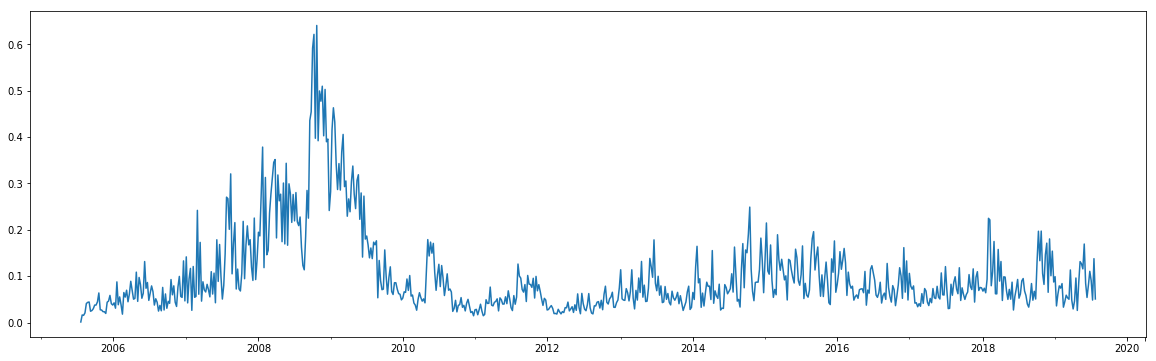

In [116]:
CISS.plot(figsize = (20,6))


# Compare CISS with the European Market 

In [117]:
euo_ciss= pd.read_csv('ciss_cal.csv')
euo_ciss.Date = pd.to_datetime(euo_ciss.Date) - np.timedelta64(1,'D')

us_ciss.set_index('Date',inplace = True)
euo_ciss.set_index('Date',inplace = True)

euo_ciss = euo_ciss.reset_index()
euo_ciss.Date = pd.to_datetime(euo_ciss.Date) - np.timedelta64(2,'D')
euo_ciss = euo_ciss.set_index('Date')
euo_ciss.tail()


,Calculated CISS
Date,
2019-07-16,0.038469
2019-07-23,0.037463
2019-07-30,0.067969
2019-08-06,0.119732
2019-08-13,0.144296


In [118]:
time1 = us_ciss.index[0]
time2 = euo_ciss.index[-1]

euo_ciss = euo_ciss.resample('W').mean()
us_ciss = us_ciss.resample('W').mean()

euo_ciss = euo_ciss[time1:][:-2]
us_ciss = us_ciss[:time2][:]


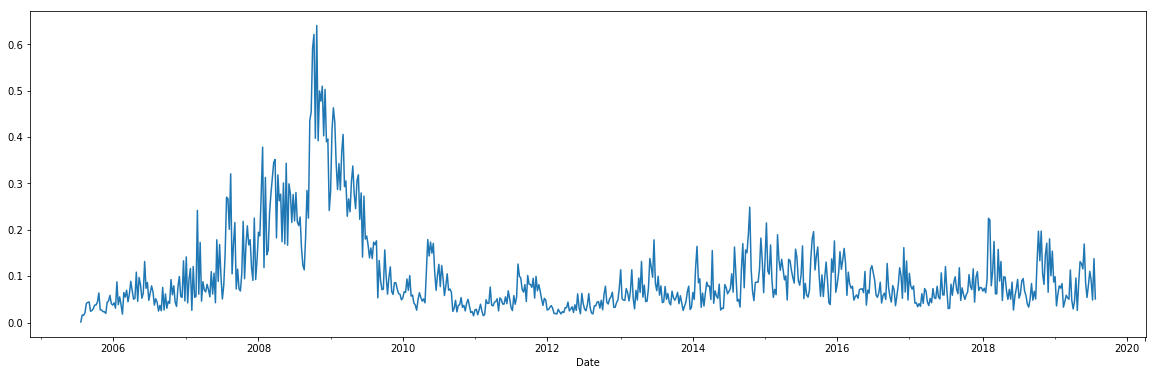

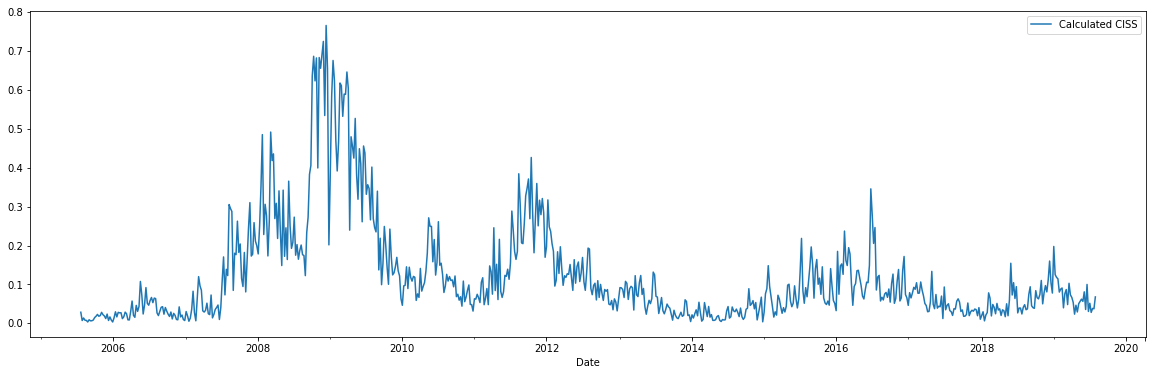

In [119]:
df['Calculated_CISS_US'].plot(figsize = (20,6), label = 'US')
euo_ciss.plot(figsize = (20,6))


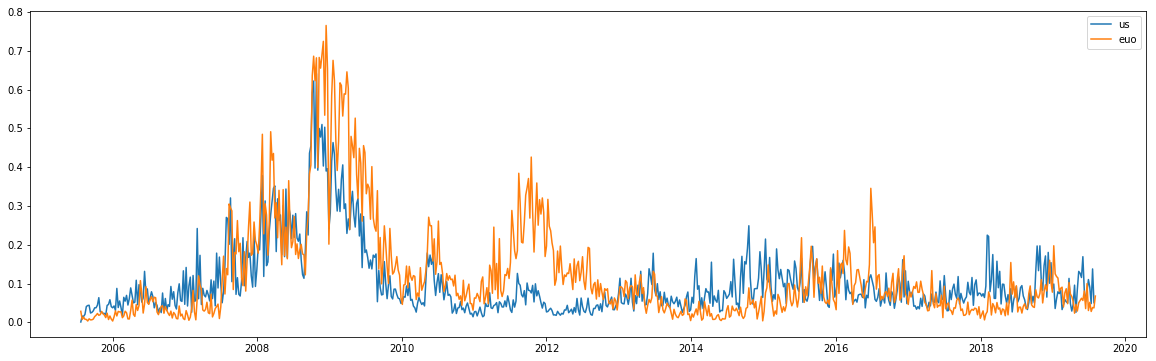

In [120]:

#us_ciss.plot(figsize = (20,6))
#euo_ciss.plot(figsize = (20,6))
plt.figure(figsize=(20,6))
plt.plot(us_ciss, label = 'us')
plt.plot(euo_ciss, label = 'euo')
plt.legend()


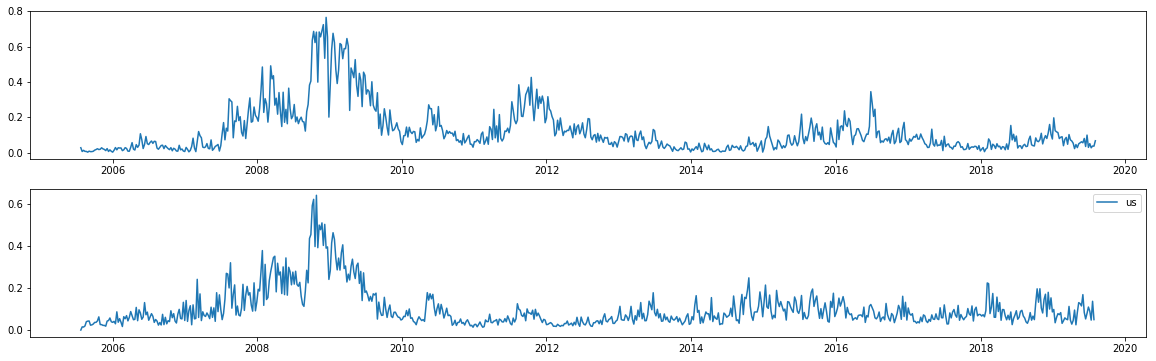

In [121]:
plt.figure(figsize=(20,6))

ax1 = plt.subplot(211)
plt.plot(euo_ciss, label = 'euo')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(us_ciss, label = 'us')

plt.legend()

In [122]:
us_ciss.Calculated_CISS_US.describe()


count    732.000000
mean       0.101212
std        0.090162
min        0.001186
25%        0.047886
50%        0.070707
75%        0.115875
max        0.640982
Name: Calculated_CISS_US, dtype: float64

In [123]:
percentile_90 = us_ciss.Calculated_CISS_US.quantile(.9) #90 percentile
percentile_75 = us_ciss.Calculated_CISS_US.quantile(.75) #75 percentile
us_ciss['regime'] = 'regime_1'


In [124]:
us_ciss.head()


,Calculated_CISS_US,regime
Date,,
2005-07-24,0.001186,regime_1
2005-07-31,0.016285,regime_1
2005-08-07,0.015461,regime_1
2005-08-14,0.020711,regime_1
2005-08-21,0.041058,regime_1


In [125]:
#us_ciss['regime'] = 'regime_2' if us_ciss.loc[us_ciss.Calculated_CISS_US > percentile_90] 
us_ciss['regime'].loc[us_ciss.Calculated_CISS_US > percentile_90] = 'regime_2'
us_ciss['regime'].loc[us_ciss.Calculated_CISS_US <= percentile_75] = 'regime_0'


/Users/keyang/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [126]:
us_ciss.head()


,Calculated_CISS_US,regime
Date,,
2005-07-24,0.001186,regime_0
2005-07-31,0.016285,regime_0
2005-08-07,0.015461,regime_0
2005-08-14,0.020711,regime_0
2005-08-21,0.041058,regime_0


# import the ETF index from Quandl 

In [ ]:
ETF = pd.read_csv('ETF_clean_return.csv')
ETF.Date = pd.to_datetime(ETF.Date)
ETF.set_index('Date',inplace = True)
time = pd.to_datetime(us_ciss.index[0]).date()
ETF_new = ETF[time:]
ETF_new.head()


regression on the equally weighted 11 assets see how the Beta looks like

In [ ]:
first11 = ETF_new.columns[:11]
y = ETF_new[first11].mean(axis=1).resample('W').mean().values[:-2]

from sklearn.linear_model import LinearRegression
X = us_ciss.Calculated_CISS_US.values.reshape(-1,1)
linReg = LinearRegression()
linReg.fit(X , y)
print(linReg.coef_)
print(linReg.score)

import statsmodels.api as sm
X_constant = sm.add_constant(X)
linReg = sm.OLS(y, X_constant).fit()
linReg.summary()


# z score =  (MA(3) - MA(50) )/Sigma

In [ ]:
us_ciss['MA3'] = us_ciss.iloc[:,0].rolling(window=3).mean()
us_ciss['MA50'] = us_ciss.iloc[:,0].rolling(window=50).mean()
us_ciss['diff'] = us_ciss['MA3'] - us_ciss['MA50']
us_ciss_z = us_ciss.dropna()

std = us_ciss_z['diff'].std()
us_ciss_z['z_score'] = us_ciss_z['diff']/std
us_ciss_z.head()


In [ ]:
ETF = pd.read_csv('ETF_clean_return.csv')
ETF.Date = pd.to_datetime(ETF.Date)
ETF.set_index('Date',inplace = True)
time = pd.to_datetime(us_ciss_z.index[0]).date()
ETF_new = ETF[time:]
ETF_new.head()

first11 = ETF_new.columns[:11]
y = ETF_new[first11].mean(axis=1).resample('W').mean().values[:-2]

from sklearn.linear_model import LinearRegression
X = us_ciss_z.z_score.values.reshape(-1,1)
linReg = LinearRegression()
linReg.fit(X , y)
print(linReg.coef_)
print(linReg.score)

import statsmodels.api as sm
X_constant = sm.add_constant(X)
linReg = sm.OLS(y, X_constant).fit()
linReg.summary()

# Statistical analysis of the z_score in different regimes

In [ ]:
#whole time horizon 
us_ciss_z.z_score.describe()


In [ ]:
us_ciss_r0 = us_ciss_z[us_ciss_z['regime'] == 'regime_0']
us_ciss_r1 = us_ciss_z[us_ciss_z['regime'] == 'regime_1']
us_ciss_r2 = us_ciss_z[us_ciss_z['regime'] == 'regime_2']


In [ ]:
#regime0
us_ciss_r0.z_score.describe()


In [ ]:
r0 = us_ciss_z.loc[us_ciss_r0.index]
r0.head()


In [ ]:
#regime1
us_ciss_r1.z_score.describe()


In [ ]:
r1 = us_ciss_z.loc[us_ciss_r1.index]
r1.head()


In [ ]:
#regime2
us_ciss_r2.z_score.describe()


In [ ]:
r2 = us_ciss_z.loc[us_ciss_r2.index]
r2.head()


# Run regression on different regimes see how Beta's look like 

In [ ]:
ETF = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/ETF_clean_return.csv')
ETF.Date = pd.to_datetime(ETF.Date)
ETF.Date = pd.to_datetime(ETF.Date) - np.timedelta64(2,'D')
ETF.set_index('Date',inplace = True)
time = pd.to_datetime(us_ciss_z.index[0]).date()
ETF_new = ETF[time:][1:]

us_ciss_etf_r0 = ETF_new.loc[r0[1:].index].fillna(method='ffill') #since ETF_new does not have 2006-07-02 value
us_ciss_etf_r1 = ETF_new.loc[r1.index].fillna(method='ffill')
us_ciss_etf_r2 = ETF_new.loc[r2.index].fillna(method='ffill')

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#df is the etf return and df_r is the us ciss value in different regimes
def regression(df,df_r):
    first11 = df.columns[:11]
    y = df[first11].mean(axis=1)
       
    X = df_r.z_score.values.reshape(-1,1)
    linReg = LinearRegression()
    linReg.fit(X , y)
    #print(linReg.coef_)
    #print(linReg.score)

    X_constant = sm.add_constant(X)
    linReg = sm.OLS(y, X_constant).fit()
    return linReg.summary()


# Regime 0

In [ ]:
regression(us_ciss_etf_r0,r0[1:])


# Regime 1

In [ ]:
regression(us_ciss_etf_r1,r1)


# Regime 2

In [ ]:
regression(us_ciss_etf_r2,r2)


# Exponentially weighted moving average

Here we use Lambda(3) and Lambda (50) to find the Z-score again

In [ ]:
us_ciss.head()


In [ ]:
'''

def MA(n):
    
    def sumOfGP(initial_val, lda, t):    
        sum = 0
        i = 0
        while i < t - 1 : 
            sum = sum + initial_val 
            initial_val = initial_val * lda 
            i = i + 1
        return sum
    
    exp_df = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/Exponential weight functions and half lifes.csv')
    w = np.zeros(n)
    moving_avg = np.zeros(len(us_ciss.Calculated_CISS_US)-n+1)
    
    ida = exp_df.ida[n-1]
    initial_val = exp_df.ida[n-1]
    t = int(exp_df.tau[n-1])
    denominator = sumOfGP(ida,initial_val,t)
    
    for i in range(n):
        w[i] = ida**(i+1)/denominator
            
    for i in range(len(us_ciss.Calculated_CISS_US)-n+1):
        for j in range(len(w)):
            moving_avg[i] = moving_avg[i] + us_ciss.Calculated_CISS_US[i]*w[j]
    
    return moving_avg
                      
    
'''

In [ ]:
us_ciss.head()

In [ ]:
def Sum_lda(lda,n):    
        
    t = 250 #moving window 
        
    def sumOfGP(lda):   
        initial_val = lda
        sum = 0
        i = 0
        while i < t - 1 : 
            sum = sum + initial_val
            initial_val = initial_val * lda 
            i = i + 1
        return sum 
        
    denominator = sumOfGP(lda)
    def solve_lda(n):
        sum_timeseries = 0
        for i in range (n,t+1):
            sum_timeseries  = sum_timeseries + lda**(i)/denominator
        return sum_timeseries

    return solve_lda(n) - 0.5


In [ ]:

'''
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
solve(Sum_lda(x,40), x)

'''

In [ ]:
def bisection(n): 
    
    a = 0.75 #lower bound 
    b = 1 #upper bound 

    if (Sum_lda(a,n) * Sum_lda(b,n) >= 0): 
        print("You have not assumed right a and b\n") 
        return

    c = a 
    while ((b-a) >= 0.00001): 

        # Find middle point 
        c = (a+b)/2

        # Check if middle point is root 
        if (Sum_lda(c,n) == 0.0): 
            break

        # Decide the side to repeat the steps 
        if (Sum_lda(c,n)*Sum_lda(a,n) < 0): 
            b = c 
        else: 
            a = c 
             
    print("The value of lambda_" + str(n) + " is:","%.4f"%c) 
    return c
    

bisection(40)
bisection(4)

In [ ]:
def MA(n):
    
    w = np.zeros(n)
    moving_avg = np.zeros(len(us_ciss.Calculated_CISS_US)-n+1)    
    lda = bisection(n)
    t = 250 #moving window

    def sumOfGP(lda):   
        initial_val = lda
        sum = 0
        i = 0
        while i < t - 1 : 
            sum = sum + initial_val
            initial_val = initial_val * lda 
            i = i + 1
        return sum 
    
    denominator = sumOfGP(lda)    
    for i in range(n):
        w[i] = lda**(i+1)/denominator
            
    for i in range(len(us_ciss.Calculated_CISS_US)-n+1):
        for j in range(len(w)):
            moving_avg[i] = moving_avg[i] + us_ciss.Calculated_CISS_US[i]*w[j]
    
    return moving_avg
                      
def get_data_frame(n):
    ma = pd.DataFrame(data = MA(n), index = us_ciss.index[n-1:])
    ma.columns = ['MA_exp'+ str(n)]

    us_ciss_exp = us_ciss[['Calculated_CISS_US','regime']]
    df_ma = pd.concat([us_ciss_exp,ma['MA_exp'+str(n)]],axis = 1)

    return df_ma

   

In [ ]:
#get_data_frame(50).columns[-1]
df_ciss_exp = pd.concat([get_data_frame(4),
                    get_data_frame(40).drop(columns =['Calculated_CISS_US','regime'])],axis = 1)


df_ciss_exp['diff'] = df_ciss_exp['MA_exp4'] - df_ciss_exp['MA_exp40']
df_ciss_exp_z = df_ciss_exp.dropna()

std_exp = df_ciss_exp_z['diff'].std()
df_ciss_exp_z['z_score'] = df_ciss_exp_z['diff']/std_exp
df_ciss_exp_z.head()

In [ ]:
def exp_reg(us_ciss_z):
    ETF = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]+1

    first11 = ETF_new.columns[:11]
    y = ETF_new[first11].mean(axis=1).cumprod().resample('W').last().values[:-2]-1

    from sklearn.linear_model import LinearRegression
    X = us_ciss_z.z_score.values.reshape(-1,1)
    linReg = LinearRegression()
    linReg.fit(X , y)
    #print(linReg.coef_)
    #print(linReg.score)

    import statsmodels.api as sm
    X_constant = sm.add_constant(X)
    linReg = sm.OLS(y, X_constant).fit()
    return linReg


In [ ]:
def exp_reg1(us_ciss_z):
    ETF = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]+1

    first11 = ETF_new.columns[:11]
    y = ETF_new[first11].mean(axis=1).cumprod().resample('M').last().values[:-1]-1

    from sklearn.linear_model import LinearRegression
    import statsmodels.api as sm
    us_ciss_z = us_ciss_z.resample('M').last()
    X = us_ciss_z.z_score.values.reshape(-1,1)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    X_constant = sm.add_constant(X)
    model = sm.OLS(y, X_constant).fit()
    return model



In [ ]:
exp_reg(df_ciss_exp_z).summary()


In [ ]:
exp_reg1(df_ciss_exp_z).summary()

# Calculate the Beta's of the expoentially weighted average of the different regions

In [ ]:
'''

#whole time horizon 
def calculate_beta(us_ciss_z):
    us_ciss_r0 = us_ciss_z[us_ciss_z['regime'] == 'regime_0']
    us_ciss_r1 = us_ciss_z[us_ciss_z['regime'] == 'regime_1']
    us_ciss_r2 = us_ciss_z[us_ciss_z['regime'] == 'regime_2']

    r0 = us_ciss_z.loc[us_ciss_r0.index]
    r1 = us_ciss_z.loc[us_ciss_r1.index]
    r2 = us_ciss_z.loc[us_ciss_r2.index]

    ETF = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.Date = pd.to_datetime(ETF.Date) - np.timedelta64(2,'D')
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]

    us_ciss_etf_r0 = ETF_new.loc[r0.index].fillna(method='ffill') #since ETF_new does not have 2006-07-02 value
    us_ciss_etf_r1 = ETF_new.loc[r1.index].fillna(method='ffill')
    us_ciss_etf_r2 = ETF_new.loc[r2.index].fillna(method='ffill')
    
    return us_ciss_etf_r0, us_ciss_etf_r1, us_ciss_etf_r2,r0,r1,r2

#df is the etf return and df_r is the us ciss value in different regimes
def regression(df,df_r):
    first11 = df.columns[:11]
    y = df[first11].mean(axis=1)

    X = df_r.z_score.values.reshape(-1,1)
    linReg = LinearRegression()
    linReg.fit(X , y)
    #print(linReg.coef_)
    #print(linReg.score)

    X_constant = sm.add_constant(X)
    linReg = sm.OLS(y, X_constant).fit()
    return linReg.summary()



regression(calculate_beta(df_ciss_exp_z)[0][1:],calculate_beta(df_ciss_exp_z)[3][1:])
regression(calculate_beta(df_ciss_exp_z)[1],calculate_beta(df_ciss_exp_z)[4])
regression(calculate_beta(df_ciss_exp_z)[2],calculate_beta(df_ciss_exp_z)[5])

'''



# Dummy variable regression model for the whole regime period

In [ ]:
df_ciss_exp_z.head()

In [ ]:
df = df_ciss_exp_z
df['normal'] = (df['z_score'] <= -1)*df['z_score']
df['high'] = ((df['z_score'] < 1) & (df['z_score'] > -1))*df['z_score']
df['stress'] = (df['z_score'] >= 1)*df['z_score']


In [ ]:
df.head()

In [ ]:
def dummy_reg(us_ciss_z):
    ETF = pd.read_csv('ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]+1

    first11 = ETF_new.columns[:11]
    y = ETF_new[first11].mean(axis=1).cumprod().resample('W').last().values[:-2]-1

    from sklearn.linear_model import LinearRegression
    import statsmodels.api as sm
    us_ciss_z = us_ciss_z.resample('W').last()
    X = us_ciss_z[['stress','high']]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    X_constant = sm.add_constant(X)
    model = sm.OLS(y, X_constant).fit()
    return model



In [ ]:
dummy_reg(df).summary()

In [ ]:
def dummy_reg1(us_ciss_z):
    ETF = pd.read_csv('ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]+1

    first11 = ETF_new.columns[:11]
    y = ETF_new[first11].mean(axis=1).cumprod().resample('M').last().values[:-1]-1

    from sklearn.linear_model import LinearRegression
    import statsmodels.api as sm
    us_ciss_z = us_ciss_z.resample('M').last()
    X = us_ciss_z[['stress','high']]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    X_constant = sm.add_constant(X)
    model = sm.OLS(y, X_constant).fit()
    return model


In [ ]:
dummy_reg1(df).summary()

# Regression on Dummy regimes:

In [ ]:
df1 = df_ciss_exp_z
df1['normal'] = (df['z_score'] <= -1)*1
df1['high'] = ((df['z_score'] < 1) & (df['z_score'] > -1))*1
df1['stress'] = (df['z_score'] >= 1)*1

In [ ]:
df1.head()

In [ ]:
def dummy_reg(us_ciss_z):
    ETF = pd.read_csv('/Users/guapofish/Desktop/MACRO-CISS-master/ETF_clean_return.csv')
    ETF.Date = pd.to_datetime(ETF.Date)
    ETF.set_index('Date',inplace = True)
    time = pd.to_datetime(us_ciss_z.index[0]).date()
    ETF_new = ETF[time:]+1

    first11 = ETF_new.columns[:11]
    y = ETF_new[first11].mean(axis=1).cumprod().resample('W').last().values[:-2]-1

    from sklearn.linear_model import LinearRegression
    import statsmodels.api as sm
    us_ciss_z = us_ciss_z.resample('W').last()
    X = us_ciss_z[['stress','high']]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    X_constant = sm.add_constant(X)
    model = sm.OLS(y, X_constant).fit()
    return model



In [ ]:
dummy_reg(df1).summary()

In [ ]:
dummy_reg1(df1).summary()

# Test the Heteroskedasticity ----- J-P Test

# Test the Heteroskedasticity ----- White Test

# Reg1 ETF weekly return ~ Z_score

In [ ]:
sm.stats.diagnostic.het_white(exp_reg(df_ciss_exp_z).resid, exp_reg(df_ciss_exp_z).model.exog)

hetero存在的情况下能不能用OLS回归-----
ergodic stationary process 

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(exp_reg(df_ciss_exp_z),nlags = 5))>0

# Reg2 ETF monthly return ~ Z_score

In [ ]:
sm.stats.diagnostic.het_white(exp_reg1(df_ciss_exp_z).resid, exp_reg1(df_ciss_exp_z).model.exog)

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(exp_reg1(df_ciss_exp_z),nlags = 5))>0

# Reg3 ETF weekly cumulative return ~ high + stress

In [ ]:
sm.stats.diagnostic.het_white(dummy_reg(df).resid, dummy_reg(df).model.exog)

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(dummy_reg(df),nlags = 5))>0

# reg4 ETF monthly cumulative return ~ high + stress

In [ ]:
sm.stats.diagnostic.het_white(dummy_reg1(df).resid, dummy_reg1(df).model.exog)

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(dummy_reg1(df),nlags = 5))>0

# reg5 ETF weekly cumulative return ~ Dhigh + Dstress

In [ ]:
sm.stats.diagnostic.het_white(dummy_reg(df1).resid, dummy_reg(df1).model.exog)

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(dummy_reg(df1),nlags = 5))>0

# reg6 ETF monthly cumulative return ~ Dhigh + Dstress

In [ ]:
sm.stats.diagnostic.het_white(dummy_reg1(df1).resid, dummy_reg1(df1).model.exog)

In [ ]:
np.linalg.eigvals(sm.stats.sandwich_covariance.cov_hac(dummy_reg1(df1),nlags = 5))>0